# Estimaciones COVID-19 en Colombia

Dada la coyuntura mundial que estamos viviendo, he decidido hacer unas estimaciones sencillas (Regresión Polinomica)sobre los casos de COVID-19 en Colombia. Se trata de proyectar los casos en los siguientes 30 dias.

La fuente de datos que uso es una URL JSON que tiene publicada el Instituto Nacional de Salud.  Esta fuente tiene el reporte detallado de cada caso y es actualizada al menos 2 veces al día.

La URL de la fuente de datos es: https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD (URL Anterior: https://e.infogram.com/api/live/flex/bc384047-e71c-47d9-b606-1eb6a29962e3/664bc407-2569-4ab8-b7fb-9deb668ddb7a)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from IPython.core.display import display, HTML

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [2]:
uri = 'https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD'
data = pd.read_csv(uri)
data.rename(columns={"Tipo*": "Tipo", "atención": "Atención", "Departamento o Distrito ": "Departamento", "Fecha diagnostico": "Fecha de diagnostico"}, inplace = True)

In [3]:

# Ajuste de formato de fechas
data['Fecha de diagnostico'] = pd.to_datetime(data['Fecha de diagnostico'], dayfirst = True, errors = 'coerce')
data['Fecha de notificación'] = pd.to_datetime(data['Fecha de notificación'], dayfirst = True, errors = 'coerce')
data['Fecha recuperado'] = pd.to_datetime(data['Fecha recuperado'], dayfirst = True, errors = 'coerce')
data['Fecha de muerte'] = pd.to_datetime(data['Fecha de muerte'], dayfirst = True, errors = 'coerce')
data['fecha reporte web'] = pd.to_datetime(data['fecha reporte web'], dayfirst = True, errors = 'coerce')
# Ajuste de columna Atención por uso de mayusculas mezcladas
data['Atención'] = data['Atención'].str.lower()
data['Tipo'] = data['Tipo'].str.capitalize()
data['Sexo'] = data['Sexo'].str.capitalize()
# Ajuste de columna Edad por elementos duplicados por dobles espacios
data['Edad'] = data['Edad'].replace('\s+', ' ', regex=True)
# Ajuste de columna Edad por elementos duplicados por dobles espacios y paises múltiples separados por guiones
data['País de procedencia'] = data['País de procedencia'].str.split('-').str[0].replace('\s+', ' ', regex=True)
data['País de procedencia'] = data['País de procedencia'].str.strip()
#data.set_index('ID de caso', inplace=True)
data['Sexo'] = data['Sexo'].astype('category')
data['Atención'] = data['Atención'].astype('category')
data['Tipo'] = data['Tipo'].astype('category')
data['Edad'] = data['Edad'].astype(int)
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '>90']
data['rango_edades'] = pd.cut(data['Edad'], range(0,110,10), labels = labels)
labels = ['bebe', 'niño', 'adolescente', 'joven', 'adulto', 'adulto mayor']
data['tipo_edades'] = pd.cut(data['Edad'], [0, 6, 12, 19, 27, 60, 100], labels = labels)
data['tipo_edades'] = data['tipo_edades'].astype('category')

In [12]:
casos_x_fecha = data.groupby(['Fecha de diagnostico']).size().fillna(0)

In [13]:
y = list(casos_x_fecha)
x = list(range(1, len(y)+1))
x = np.array(x)[:,np.newaxis]
y = np.array(y)
poly_model = make_pipeline(PolynomialFeatures(degree=2, include_bias=True,interaction_only=False, order='C'), 
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False))
poly_model.fit(x,y)


Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [17]:
x_pred = np.arange(1, len(x)+30)
x_pred2 = np.arange(len(x), len(x)+30)
y_pred2 = poly_model.predict(x_pred2[:, np.newaxis])
y_train = poly_model.predict(x)

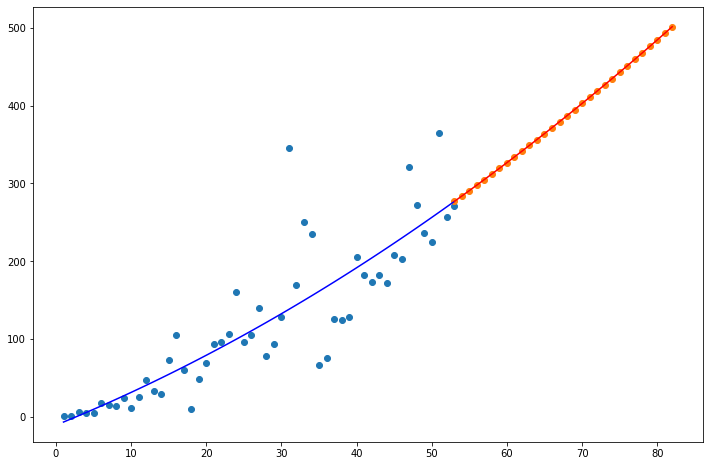

In [18]:
plt.figure(figsize=(12,8))
plt.plot(x,y_train,color='blue')
plt.scatter(x,y)
plt.plot(x_pred2, y_pred2, color='r')
plt.scatter(x_pred2, y_pred2)

In [8]:
from sklearn.model_selection import GridSearchCV

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))
                         
param_grid = {'polynomialfeatures__degree': np.arange(10), 'linearregression__fit_intercept': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv = 5)
grid.fit(x,y)

/Users/luisk/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('linearregression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'linearregression__fit_intercept': [True, False],
                        

In [9]:
grid.best_estimator_

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
                                  normalize=False))],
         verbose=False)